In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score

In [103]:
df = pd.read_csv('train.csv')

In [3]:
def normalize(L):
    avg = np.mean(L)
    var = np.var(L)
    sig = var**0.5
    res = [(e-avg)/sig for e in L]
    return res

In [4]:
def binary_sex(L):
    for i in range(len(L)):
        if L[i] == 'male':
            L[i] = 1
        elif L[i] == 'female':
            L[i] = -1
        else:
            L[i] = 'NaN'
    return L

In [5]:
def name_to_num(L):
    res = [len(e) for e in L]
    return res

In [104]:
df['Age'] = normalize(df['Age'])
df['Fare'] = normalize(df['Fare'])
df['Pclass'] = normalize(df['Pclass'])
df['Sex'] = binary_sex(df['Sex'])
df['Name'] = normalize(name_to_num(df['Name']))
df['Weight'] = 1

/home/thoreau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/thoreau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [105]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Weight
0,1,0,0.827377,-0.427451,1,-0.530377,1,0,A/5 21171,-0.502445,NaN,S,1
1,2,1,-1.566107,2.590962,-1,0.571831,1,0,PC 17599,0.786845,C85,C,1
2,3,1,0.827377,-0.535252,-1,-0.254825,0,0,STON/O2. 3101282,-0.488854,NaN,S,1
3,4,1,-1.566107,1.836359,-1,0.365167,1,0,113803,0.420730,C123,S,1
4,5,0,0.827377,-0.319651,1,0.365167,0,0,373450,-0.486337,NaN,S,1


In [216]:
class Classifier:
    def __init__(self,caracteristique):
        self.caracteristique = caracteristique
        self.weights = df[['Weight',caracteristique]].dropna()
        self.weights = np.array(self.weights)
        self.weights = self.weights[:,0]
        passenger = df[['Survived',caracteristique]].dropna()
        self.passenger = np.array(passenger, dtype='float')
        self.label_train = self.passenger[:,0]
        self.set_train = self.passenger[:,1:passenger.shape[0]]
        self.clf = svm.SVC(kernel="linear")
        self.clf.fit(self.set_train,self.label_train)
    
    def predict(self):
        self.pred = self.clf.predict(self.set_train)
        return self.pred
    
    def get_error(self):
        pred = self.predict()
        self.errors = [pred==self.label_train][0]
        self.errors = np.reshape(self.errors,(self.errors.shape[0],1))
        self.errors = self.errors*self.weights
        self.error = 1 - sum(self.errors)[0]/len(self.errors)
        return self.error

In [217]:
#Définition des classifieurs faibles
clf_sex = Classifier('Sex')
clf_age = Classifier('Age')
clf_fare = Classifier('Fare')
clf_class = Classifier('Pclass')
clf_name = Classifier('Name')

classifiers = {
    'clf_sex': {'clf': clf_sex, 'error': clf_sex.get_error()},
    'clf_age': {'clf': clf_age, 'error': clf_age.get_error()},
    'clf_fare': {'clf': clf_fare, 'error': clf_fare.get_error()},
    'clf_class': {'clf': clf_class, 'error': clf_class.get_error()},
    'clf_name': {'clf': clf_name, 'error': clf_name.get_error()}
}

In [220]:
def best_classifier(classifiers):
    classifiers_sorted = [k for k, v in sorted(classifiers.items(), key=lambda item: item[1]['error'])]
    best_clf = classifiers_sorted[0]
    return classifiers[best_clf]['clf']

In [221]:
def ens():
    error = best_classifier(classifiers).get_error()
    alpha = 0.5*np.log((1-error)/error)
    

Distribution de l'âge

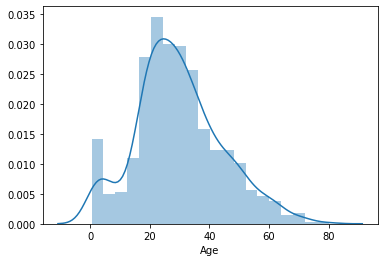

In [4]:
sns.distplot(df['Age'].dropna())

Distribution de l'âge parmi les survivants

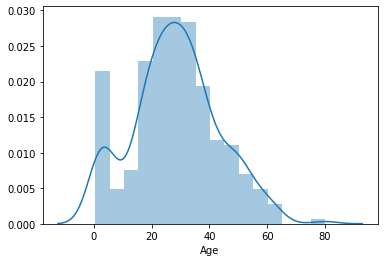

In [5]:
sns.distplot(df['Age'].where(df['Survived']==1).dropna())

Survivants hommmes / femmes

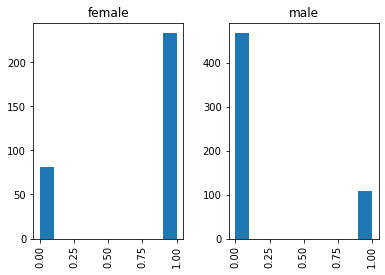

In [6]:
A = df.groupby('Sex').agg('Survived').sum()
ax = df.hist(column='Survived', by='Sex')

In [167]:
# passenger = df[['Survived','Age','Fare','Pclass','Sex','Name']].dropna()
passenger = df[['Survived','Sex']].dropna()
passenger = np.array(passenger, dtype='float')
label_train = passenger[:,0]
set_train = passenger[:,1:passenger.shape[0]]

clf = svm.SVC(kernel="linear")
clf.fit(set_train,label_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [169]:
pred = clf.predict(set_train)
print(confusion_matrix(label_train,pred))
print(accuracy_score(label_train, pred, normalize=True))

[[468  81]
 [109 233]]
0.7867564534231201


In [6]:
df_with_cabin = df[df.Cabin.isnull() == False]
n_tot = len(df_with_cabin)
n_survived = len(df_with_cabin[df_with_cabin.Survived == 1])
ratio = n_survived/n_tot*100
print('Pourcentage de personnes ayant survécu :', round(ratio,2),'%')

Pourcentage de personnes ayant survécu : 66.67 %


In [17]:
%qtconsole

In [8]:
df_age_fare = df[['Age','Fare']].dropna()
set_ = preprocessing.scale(df_age_fare)
label = df[df.Age.isnull()== False][['Survived']].values
set_train, set_test, label_train, label_test = train_test_split(set_, label, test_size=0.33)

NameError: name 'train_test_split' is not defined

In [173]:
parameters = {'n_neighbors':[e for e in range(1,10)]}
classifier = KNeighborsClassifier(parameters,algorithm='auto')
clf = GridSearchCV(classifier, parameters)
clf.fit(set_train, label_train)
clf.best_estimator_

/home/thoreau/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thoreau/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thoreau/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/thoreau/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: Data

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')

In [176]:
classifier = KNeighborsClassifier(n_neighbors=8,algorithm='auto')
classifier.fit(set_train, label_train)
label_pred = classifier.predict(set_test)
print(confusion_matrix(label_test, label_pred))
print(accuracy_score(label_test, label_pred))

[[122  25]
 [ 55  34]]
0.6610169491525424


/home/thoreau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
